In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils import rnmse
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from skorch import NeuralNet
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)

In [2]:
x = torch.cat([torch.load("dataset/x_train.pt"), torch.load("dataset/x_train_2.pt")])
y = torch.cat([torch.load("dataset/y_train.pt"), torch.load("dataset/y_train_2.pt")])
c = torch.cat([torch.load("dataset/c_train.pt"), torch.load("dataset/c_train_2.pt")])

x_test = torch.load("dataset/x_test.pt")
y_test = torch.load("dataset/y_test.pt")
c_test = torch.load("dataset/c_test.pt")

In [3]:
x0, y0, c0 = x[0], y[0], c[0]

In [4]:
x0.shape

torch.Size([256, 128])

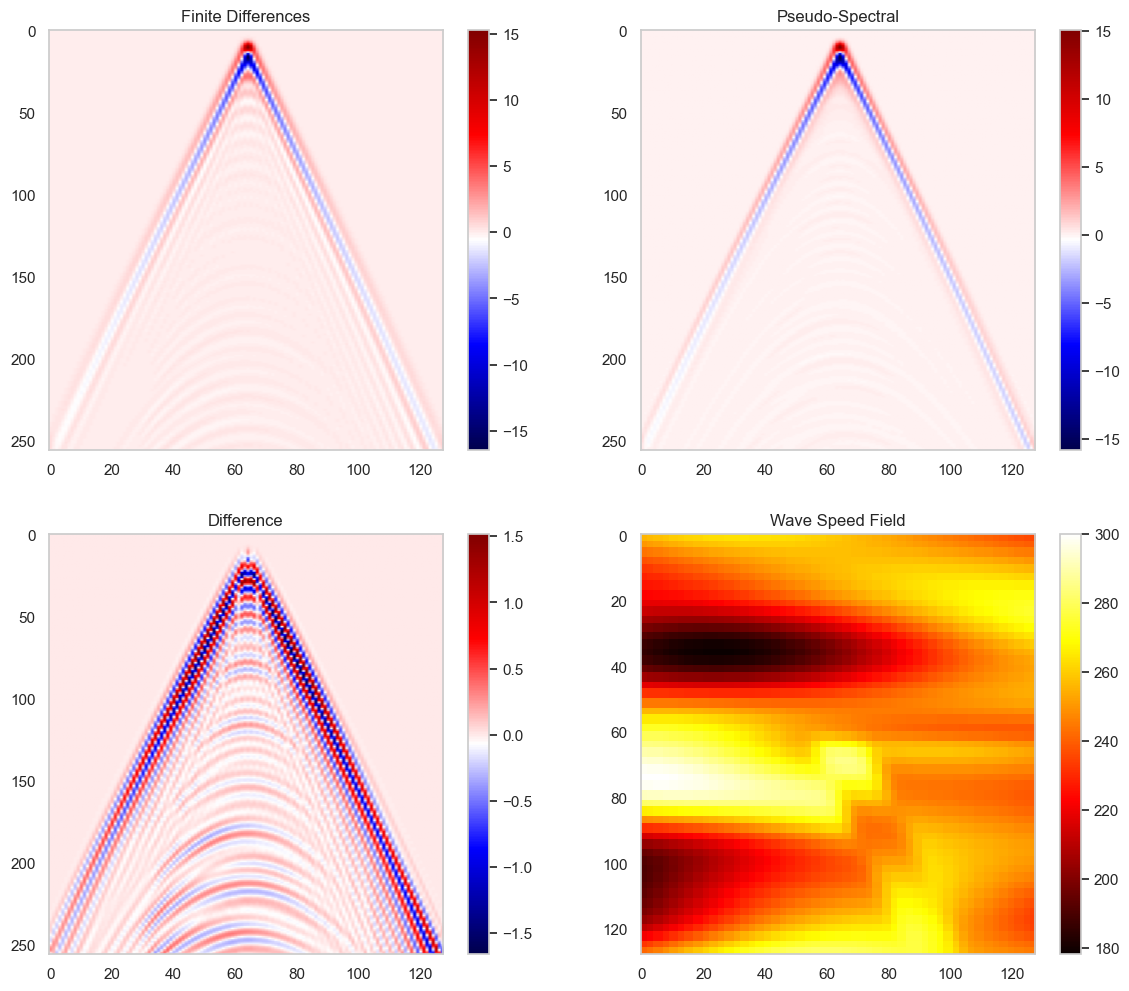

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
m = ax[0, 0].imshow(x0, aspect='auto', cmap='seismic')
ax[0, 0].set_title("Finite Differences")
plt.colorbar(m)
ax[0, 0].grid(False)
m = ax[0, 1].imshow(y0, aspect='auto', cmap='seismic')
ax[0, 1].set_title("Pseudo-Spectral")
ax[0, 1].grid(False)
plt.colorbar(m)
m = ax[1, 0].imshow((x0-y0), aspect='auto', cmap='seismic')
ax[1, 0].set_title("Difference")
ax[1, 0].grid(False)
plt.colorbar(m)
m = ax[1, 1].imshow(c0, aspect='auto', cmap='hot')
ax[1, 1].set_title("Wave Speed Field")
ax[1, 1].grid(False)
plt.colorbar(m)
plt.savefig("sample_example.jpg", dpi=150)
plt.show()

The initial error between FD and PS is evaluated.

In [6]:
print(f"Train RNSME: {rnmse(x, y)}")
print(f"Test RNSME: {rnmse(x_test, y_test)}")

Train RNSME: 0.38560399413108826
Test RNSME: 0.38336923718452454


First question: how well can the problem of getting $y$ (PS), knowing $x$ (FD) using a linear regression be solved ?

In [7]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [8]:
print(torch.mean(y-x))
print(torch.std(y-x))

tensor(5.1787e-07)
tensor(0.2418)


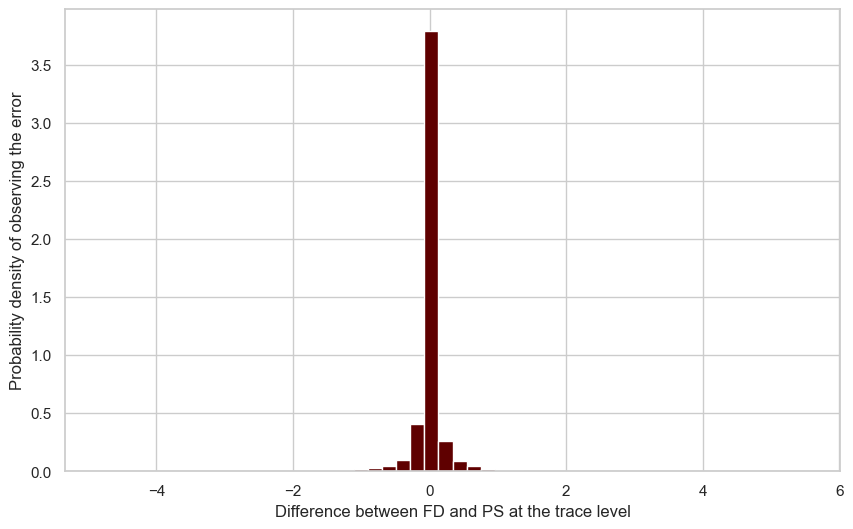

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(y_np[:1024].flatten()-x_np[:1024].flatten(), density=True, bins=50)
plt.grid(True)
plt.xlabel("Difference between FD and PS at the trace level")
plt.ylabel("Probability density of observing the error")
plt.savefig("error_analysis.jpg", dpi=150)
plt.show()

In [11]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

def get_rnmse():
    return rnmse

  0%|          | 0/10 [00:00<?, ?it/s]

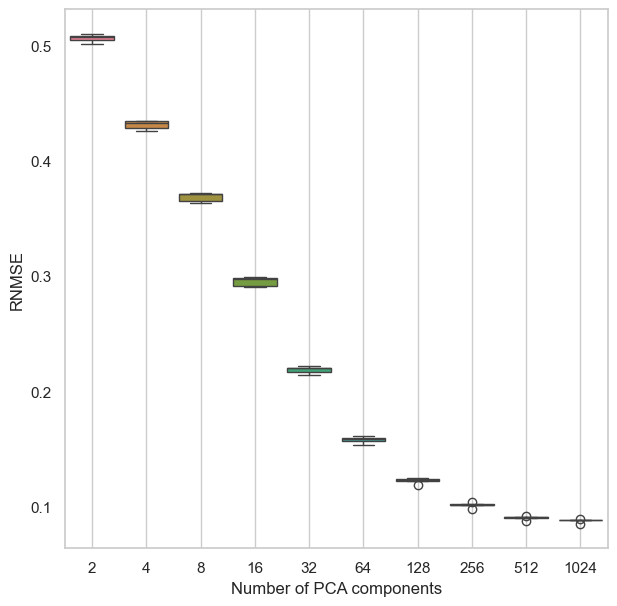

In [14]:
PCA_eval = True
n_points = y_np_reshaped.shape[0]
if PCA_eval:
    pca_errors = {i: [] for i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}
    for n_components in tqdm(pca_errors):
        pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=n_components),
            check_inverse=False
        )
        pca_errors[n_components] = cross_val_score(
            pipe_lm,
            x_np_reshaped[:n_points], y_np_reshaped[:n_points],
            cv=5,
            scoring=scorer_rnmse
        )
    plt.figure(figsize=(7, 7))
    sns.boxplot(pd.DataFrame(pca_errors))
    plt.grid()
    plt.xlabel("Number of PCA components")
    plt.ylabel("RNMSE")
    plt.savefig('pca_error.jpg', dpi=150)

Now we try a MLP.

In [6]:
n_components = 512

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim=n_components, output_dim=n_components):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class MLP2(nn.Module):
    def __init__(self, input_dim=128, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x.unsqueeze(0)).squeeze()

In [9]:
class CNN(nn.Module):
    def __init__(self, input_dim=n_components, output_dim=n_components):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.head(self.features(x.unsqueeze(1)))

In [10]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding='same')
        )

    def forward(self, x):
        return (self.features(x.unsqueeze(1))).squeeze()

Now we do the cross validation for each of the models.

In [12]:
device = 'mps'
n_points = 4096#x_np.shape[0]
n_epochs = 64
scores = {}

In [13]:
pipe_lm = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("lm", LinearRegression(n_jobs=-1))
    ]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_mlp = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("mlp", NeuralNet(
            MLP,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_mlp2 = Pipeline([
        ("mlp", NeuralNet(
            MLP2,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))])

pipe_cnn = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("cnn", NeuralNet(
            CNN,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_cnn2 = Pipeline([
        ("mlp", NeuralNet(
            CNN2,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))])

pipe_gbm = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("gmb", ExtraTreesRegressor())
    ]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

In [14]:
scores["LM"] = cross_val_score(
    pipe_lm,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

In [20]:
scores["MLP on PCA"] = cross_val_score(
    pipe_mlp,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9959        0.9872  3.3865
      2        0.9720        0.9453  0.1788
      3        0.8982        0.8419  0.1604
      4        0.7750        0.7166  0.1591
      5        0.6699        0.6438  0.2001
      6        0.6169        0.6085  0.1814
      7        0.5885        0.5882  0.1796
      8        0.5688        0.5721  0.2117
      9        0.5524        0.5580  0.2062
     10        0.5374        0.5456  0.1936
     11        0.5237        0.5344  0.2441
     12        0.5101        0.5230  0.2511
     13        0.4971        0.5128  0.1963
     14        0.4849        0.5029  0.1877
     15        0.4731        0.4934  0.2335
     16        0.4618        0.4846  0.2750
     17        0.4513        0.4766  0.2501
     18        0.4415        0.4693  0.1588
     19        0.4322        0.4623  0.1973
     20        0.4237        0.4555  0.1704
     21        0.4155        0.4

In [21]:
scores["CNN on PCA"] = cross_val_score(
    pipe_cnn,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9909        0.9657  2.4465
      2        0.9100        0.8669  0.2373
      3        0.7998        0.7730  0.2253
      4        0.7181        0.6948  0.2211
      5        0.6480        0.6276  0.2298
      6        0.5910        0.5793  0.3014
      7        0.5528        0.5479  0.2978
      8        0.5253        0.5250  0.2985
      9        0.5046        0.5140  0.3000
     10        0.4880        0.4975  0.2986
     11        0.4716        0.4863  0.3094
     12        0.4577        0.4773  0.2941
     13        0.4463        0.4669  0.2813
     14        0.4337        0.4588  0.3172
     15        0.4243        0.4534  0.3082
     16        0.4152        0.4458  0.3296
     17        0.4057        0.4370  0.3260
     18        0.3967        0.4284  0.3943
     19        0.3870        0.4222  0.3472
     20        0.3798        0.4146  0.3719
     21        0.3727        0.4

In [15]:
scores

{'LM': array([0.10351893, 0.10744858, 0.10586457, 0.10850541, 0.10988435])}

In [23]:
scores["MLP on Original Data"] = cross_val_score(
    pipe_mlp2,
    x_np[:n_points], y_np[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9901        0.9630  1.7515
      2        0.9193        0.8281  0.3032
      3        0.7448        0.6472  0.2974
      4        0.5989        0.5338  0.2981
      5        0.5047        0.4628  0.2994
      6        0.4472        0.4174  0.2985
      7        0.4080        0.3856  0.3024
      8        0.3805        0.3636  0.2944
      9        0.3604        0.3461  0.2858
     10        0.3438        0.3330  0.2896
     11        0.3309        0.3208  0.2975
     12        0.3194        0.3102  0.2954
     13        0.3094        0.3026  0.2967
     14        0.3012        0.2936  0.3151
     15        0.2926        0.2855  0.3155
     16        0.2852        0.2794  0.2989
     17        0.2789        0.2734  0.3064
     18        0.2730        0.2682  0.3085
     19        0.2680        0.2638  0.3305
     20        0.2637        0.2594  0.3065
     21        0.2593        0.2

In [24]:
scores["CNN on Original Data"] = cross_val_score(
    pipe_cnn2,
    x_np[:n_points], y_np[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9607        0.8859  5.4291
      2        0.7766        0.5991  2.7696
      3        0.4833        0.3617  2.8370
      4        0.3417        0.2965  2.7495
      5        0.2940        0.2707  2.6253
      6        0.2701        0.2540  2.7129
      7        0.2563        0.2424  2.5951
      8        0.2461        0.2335  2.5402
      9        0.2382        0.2268  2.5977
     10        0.2318        0.2209  2.5593
     11        0.2263        0.2159  2.5491
     12        0.2215        0.2115  2.5659
     13        0.2172        0.2075  2.5897
     14        0.2134        0.2040  2.5983
     15        0.2099        0.2007  2.6227
     16        0.2066        0.1975  2.6067
     17        0.2035        0.1945  2.6377
     18        0.2006        0.1915  2.6082
     19        0.1977        0.1887  2.6031
     20        0.1949        0.1860  2.7150
     21        0.1923        0.1

In [25]:
scores

{'LM': array([0.11446009, 0.1252825 , 0.12687892, 0.1217671 , 0.11628004]),
 'MLP on PCA': array([0.2455027 , 0.27210653, 0.25041303, 0.26514837, 0.23104309]),
 'CNN on PCA': array([0.24004443, 0.23225522, 0.23833513, 0.23250742, 0.22433065]),
 'MLP on Original Data': array([0.19575576, 0.19927792, 0.20054771, 0.20441568, 0.19219972]),
 'CNN on Original Data': array([0.15133044, 0.14737019, 0.15651481, 0.1638691 , 0.1493334 ])}

In [26]:
scores["Trees on PCA"] = cross_val_score(
    pipe_gbm,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

In [27]:
scores

{'LM': array([0.11446009, 0.1252825 , 0.12687892, 0.1217671 , 0.11628004]),
 'MLP on PCA': array([0.2455027 , 0.27210653, 0.25041303, 0.26514837, 0.23104309]),
 'CNN on PCA': array([0.24004443, 0.23225522, 0.23833513, 0.23250742, 0.22433065]),
 'MLP on Original Data': array([0.19575576, 0.19927792, 0.20054771, 0.20441568, 0.19219972]),
 'CNN on Original Data': array([0.15133044, 0.14737019, 0.15651481, 0.1638691 , 0.1493334 ]),
 'Trees on PCA': array([0.32094416, 0.32985109, 0.31702007, 0.33352238, 0.29179025])}

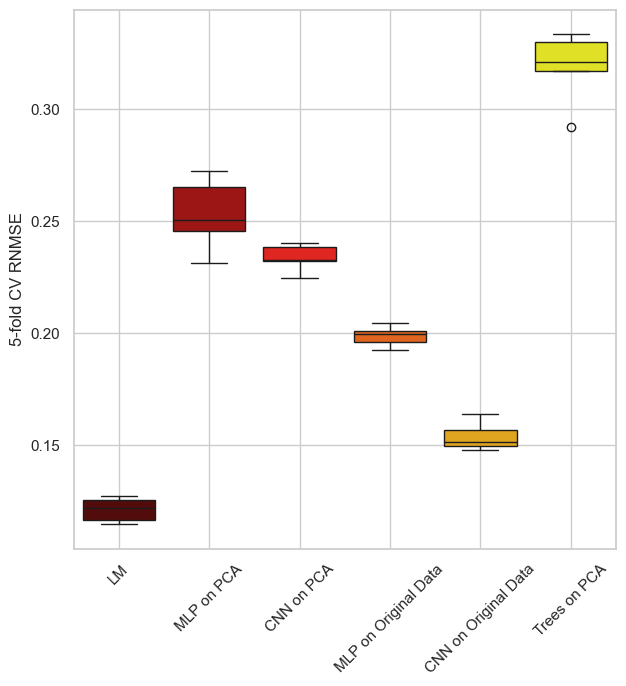

In [28]:
plt.figure(figsize=(7, 7))
sns.boxplot(pd.DataFrame(scores))
plt.grid(True)
plt.ylabel("5-fold CV RNMSE")
plt.xticks(rotation=45)
plt.savefig("5cvrnmse.jpg", dpi=150)
plt.show()